Model From https://github.com/fxia22/pointnet.pytorch/blob/master/pointnet/model.py

In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

In [2]:
class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

class PointNetCls(nn.Module):
    def __init__(self, k=2, feature_transform=False):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return x, trans, trans_feat
        #return F.log_softmax(x, dim=1), trans, trans_feat


class PointNetDenseCls(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetDenseCls, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        #x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, n_pts, self.k)
        return x, trans, trans_feat

def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

if __name__ == '__main__':
    sim_data = Variable(torch.rand(32,3,2500))
    trans = STN3d()
    out = trans(sim_data)
    print('stn', out.size())
    print('loss', feature_transform_regularizer(out))

    sim_data_64d = Variable(torch.rand(32, 64, 2500))
    trans = STNkd(k=64)
    out = trans(sim_data_64d)
    print('stn64d', out.size())
    print('loss', feature_transform_regularizer(out))

    pointfeat = PointNetfeat(global_feat=True)
    out, _, _ = pointfeat(sim_data)
    print('global feat', out.size())

    pointfeat = PointNetfeat(global_feat=False)
    out, _, _ = pointfeat(sim_data)
    print('point feat', out.size())

    cls = PointNetCls(k = 5)
    out, _, _ = cls(sim_data)
    print('class', out.size())

    seg = PointNetDenseCls(k = 3)
    out, _, _ = seg(sim_data)
    print('seg', out.size())

stn torch.Size([32, 3, 3])
loss tensor(2.0153, grad_fn=<MeanBackward0>)
stn64d torch.Size([32, 64, 64])
loss tensor(125.9736, grad_fn=<MeanBackward0>)
global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])
class torch.Size([32, 5])
seg torch.Size([32, 2500, 3])


In [3]:
#batch, dim, npoints
sim_data = Variable(torch.rand(32,3,500))
print(sim_data.shape)
classifier = PointNetDenseCls(k=1, feature_transform=None)
output = classifier(sim_data)
print(len(output))
print (output[0].shape)
print (output[1].shape)
print (output[2])

torch.Size([32, 3, 500])
3
torch.Size([32, 500, 1])
torch.Size([32, 3, 3])
None


In [4]:
stn3d=STN3d()

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# prepare some coordinates
x, y, z = np.indices((8, 8, 3))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x < 1) & (y < 1) & (z < 1)
cube2 = (x >= 2) & (y >= 2) & (z >= 2)
link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxels = cube1 | cube2 | link

# set the colors of each object
colors = np.empty(voxels.shape, dtype=object)
colors[link] = 'red'
colors[cube1] = 'blue'
colors[cube2] = 'green'
print(colors.shape)

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxels, facecolors=colors, edgecolor='k')

plt.show()

(8, 8, 3)


<Figure size 640x480 with 1 Axes>

### Source https://discuss.pytorch.org/t/which-part-of-pytorch-tensor-represents-channels/21778
The first number represents the Batchsize (N) and for tensors holding data of a dimension of 1 or above the next dimension is usually referred to as channel-dimension. The following dimensions are commonly height, width and depth.
So for 2d data (images) you have a 4d tensor of NxCxHxW which you feed into a 2d conv layer.

Note that channels only exist for convolutional layers. Linear layers for example need a shape of N x #num_features

In [69]:
class MyIterableDataset(torch.utils.data.IterableDataset):
...     def __init__(self, start, end):
...         super(MyIterableDataset).__init__()
...         assert end > start, "this example code only works with end >= start"
...         self.start = start
...         self.end = end
...
...     def __iter__(self):
...         worker_info = torch.utils.data.get_worker_info()
...         if worker_info is None:  # single-process data loading, return the full iterator
...             iter_start = self.start
...             iter_end = self.end
...         else:  # in a worker process
...             # split workload
...             per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
...             worker_id = worker_info.id
...             iter_start = self.start + worker_id * per_worker
...             iter_end = min(iter_start + per_worker, self.end)
...         return iter(range(iter_start, iter_end))
        def __next__():
            yield (np.arange(10))

In [70]:
#OR train_ds = TensorDataset(x_train, y_train)
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [71]:
from torch.utils.data import DataLoader, TensorDataset
itdataset = MyIterableDataset(start=1, end=10)
traingen, valgen = get_data(itdataset,itdataset,bs=50)

In [73]:
for i in traingen:
    print (i)

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])


In [6]:
class MyModel(torch.nn.Module):
    def __init__(self, n_points=50):
        super(MyModel, self).__init__()
        self.n_points = n_points
        self.conv1 = torch.nn.Conv1d(3, 32, 1)
        self.conv2 = torch.nn.Conv1d(32, 16, 1)
        self.conv3 = torch.nn.Conv1d(16, 1, 1)
        self.lin1 = torch.nn.Linear(n_points, 1)
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(16)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.2)
        self.batch_loss = list()

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #x = torch.max(x, 2, keepdim=True)
        x = x.view(batchsize,-1)
        #x = x.flatten()
        x = F.relu(self.lin1(x))
        #print(x.item(), "TEST")
        return x

    def trainbatch(self,x,targets,batchid):
        self.optimizer.zero_grad()
        output = self.__call__(x)
        
        loss = self.criterion(output,targets)
        loss.backward()
        self.optimizer.step()

        self.epoch_loss += loss.item()
        self.batch_loss.append(loss.item())

        #if batchid%20 == 0:
        #    print("Batch {} - batch loss: {}".format(batchid, loss.item()))

    def train(self,nepochs=5, nbatches=100, batchsize=10, valsamples=10, device="cuda"):
        epoch_loss = list()
        #self.batch_loss = list()

        for epoch in range(nepochs):

            self.epoch_loss = 0.0

            #batches number
            for b in range(nbatches):
                x = Variable(torch.rand(batchsize,3, self.n_points)).to(device)
                targets = torch.rand((batchsize,1)).to(device)
                self.trainbatch(x,targets,b)

            self.epoch_loss /= (nbatches*batchsize)
            
            print("Epoch {} - epoch loss: {}".format(epoch, self.epoch_loss))
            epoch_loss.append(self.epoch_loss)

            #validation
            self.eval()
            with torch.no_grad():
                valx = Variable(torch.rand(valsamples,3, self.n_points)).to(device)
                valy = torch.rand((valsamples,1)).to(device)
                valoutput = self.criterion(self.__call__(valx), valy)
                print("EPOCH{} VAL LOSS{} ".format(epoch, valoutput.item()))
            
        return epoch_loss

    def predict(self,x):
        with torch.no_grad():
            return self.__call__(x)

# Note from pytorch tutorial for validation

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

...

model.eval()

with torch.no_grad():

    losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
    )
    val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums

In [7]:
mymodel = MyModel(100)

In [8]:
device = torch.device("cpu")
if torch.cuda.is_available():
    #sim_data = Variable(torch.rand(2,3,1))
    device = torch.device("cuda")          # a CUDA device object
    #y = torch.ones_like(sim_data, device=device)  # directly create a tensor on GPU
    #x = sim_data.to(device)                       # or just use strings ``.to("cuda")``
    #print(x)
    #print(x.to("cpu", torch.double))       # ``.to`` can also change dtype together!
    mymodel.cuda()
#print(device)
losses = mymodel.train(25, nbatches=40, batchsize=20)

Epoch 0 - epoch loss: 0.0076060577109456065
EPOCH0 VAL LOSS0.1668531596660614 
Epoch 1 - epoch loss: 0.005089842979796231
EPOCH1 VAL LOSS0.1082000881433487 
Epoch 2 - epoch loss: 0.004716181536205113
EPOCH2 VAL LOSS0.09696033596992493 
Epoch 3 - epoch loss: 0.004608051991090179
EPOCH3 VAL LOSS0.10555189847946167 
Epoch 4 - epoch loss: 0.004447995126247406
EPOCH4 VAL LOSS0.08338163048028946 
Epoch 5 - epoch loss: 0.004393560932949185
EPOCH5 VAL LOSS0.06092967465519905 
Epoch 6 - epoch loss: 0.004525739448145032
EPOCH6 VAL LOSS0.1044011265039444 
Epoch 7 - epoch loss: 0.004643021007068455
EPOCH7 VAL LOSS0.054503995925188065 
Epoch 8 - epoch loss: 0.004625990092754364
EPOCH8 VAL LOSS0.10959811508655548 
Epoch 9 - epoch loss: 0.004408947480842471
EPOCH9 VAL LOSS0.1157497987151146 
Epoch 10 - epoch loss: 0.004353848691098392
EPOCH10 VAL LOSS0.135605126619339 
Epoch 11 - epoch loss: 0.004354234165512025
EPOCH11 VAL LOSS0.10761024802923203 
Epoch 12 - epoch loss: 0.0044186288816854356
EPOCH12

In [174]:
#print(torch.randint(0,10,(10,1)))

In [9]:
import numpy as np
"""
params = list(mymodel.parameters())
print(len(params))
print(params[0].size())
acc = np.sum([i.sum().cpu().detach().numpy() for i in params])
print([i.sum().cpu().detach().numpy() for i in params])
print(acc)
"""

'\nparams = list(mymodel.parameters())\nprint(len(params))\nprint(params[0].size())\nacc = np.sum([i.sum().cpu().detach().numpy() for i in params])\nprint([i.sum().cpu().detach().numpy() for i in params])\nprint(acc)\n'

In [10]:
mymodel.batch_loss


[0.23645393550395966,
 0.262798935174942,
 0.1733713150024414,
 0.38149285316467285,
 0.2534061670303345,
 0.29921016097068787,
 0.2787947654724121,
 0.32195448875427246,
 0.17292137444019318,
 0.18531453609466553,
 0.2167586088180542,
 0.10247047245502472,
 0.09285164624452591,
 0.1614197939634323,
 0.06339983642101288,
 0.16612139344215393,
 0.16139128804206848,
 0.11294452846050262,
 0.09682410955429077,
 0.13233092427253723,
 0.07097013294696808,
 0.13906870782375336,
 0.17193594574928284,
 0.1296897679567337,
 0.15391112864017487,
 0.11696300655603409,
 0.13369616866111755,
 0.09540408104658127,
 0.1383795142173767,
 0.05473131686449051,
 0.08303119242191315,
 0.1392793357372284,
 0.09095144271850586,
 0.08990202844142914,
 0.12417755275964737,
 0.08269289880990982,
 0.10190556198358536,
 0.09461545944213867,
 0.09860479086637497,
 0.10270500183105469,
 0.15267665684223175,
 0.1175013929605484,
 0.07270673662424088,
 0.10706044733524323,
 0.0635448545217514,
 0.09222778677940369,


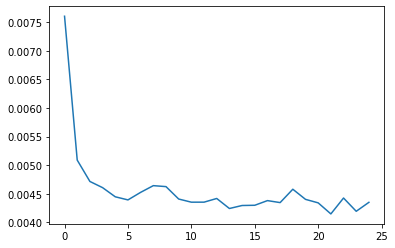

In [11]:
plt.plot(np.arange(len(losses)), losses)

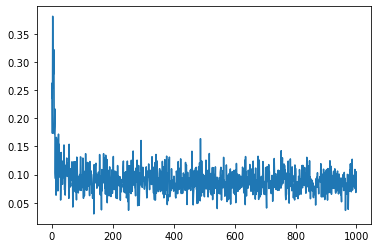

In [12]:
plt.plot(np.arange(len(mymodel.batch_loss)), mymodel.batch_loss)

In [13]:
mymodel.criterion

MSELoss()

In [14]:
print(device)
x = Variable(torch.rand(20,3,mymodel.n_points)).to(device)
targets = torch.rand((20,1)).to(device)
y_pred = mymodel.predict(x)
print("MSE {}".format(((targets - y_pred)**2).sum()))

cuda
MSE 1.960543155670166


In [15]:
y_pred, targets

(tensor([[0.4378],
         [0.4684],
         [0.4649],
         [0.4888],
         [0.5215],
         [0.5383],
         [0.4906],
         [0.4574],
         [0.4553],
         [0.5588],
         [0.4992],
         [0.4955],
         [0.5098],
         [0.4727],
         [0.4468],
         [0.4979],
         [0.5078],
         [0.5143],
         [0.4596],
         [0.5781]], device='cuda:0'), tensor([[0.1098],
         [0.6935],
         [0.1217],
         [0.5154],
         [0.6759],
         [0.0973],
         [0.4619],
         [0.3361],
         [0.7526],
         [0.8738],
         [0.1802],
         [0.1853],
         [0.2663],
         [0.8963],
         [0.3137],
         [0.1434],
         [0.5518],
         [0.0289],
         [0.0224],
         [0.0746]], device='cuda:0'))

For Classification

In [ ]:
"""
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
"""


def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)